In [3]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import utils.visualisations
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms

import utils.metrics
import utils.model

import models.mnist
import models.resnet_dropout

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("cpu")
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2070 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
transforms_train = torchvision.transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

transforms_test = torchvision.transforms.Compose([transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])

data_train = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=True, transform=transforms_train)
data_loader_train = torch.utils.data.DataLoader(data_train,
                                                batch_size=32,
                                                shuffle=True,
                                                )

data_test = torchvision.datasets.CIFAR100(
    "cifar100", download=True, train=False, transform=transforms_test)
data_loader_test = torch.utils.data.DataLoader(data_test,
                                               batch_size=32,
                                               shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
dataset_sizes = {"train": len(data_train), "val": len(data_test)}
data_loaders = {"train": data_loader_train, "val": data_loader_test}

In [7]:
model = models.resnet_dropout.ResNet18Dropout(num_classes=100).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
train_progress = utils.model.train_model(
    model, 200, optimizer, criterion, data_loaders, device)

ResNetDropout(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
      (dropout): Dropout2d(p=0.2, inplace=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

train Loss: 4.23 Acc: 0.05 Avg. conf: 0.11 Avg. max. prob: 0.07: 100%|██████████| 1563/1563 [00:47<00:00, 32.59it/s]
val Loss: 3.87 Acc: 0.09 Avg. conf: 0.15 Avg. max. prob: 0.09: 100%|██████████| 313/313 [00:03<00:00, 83.87it/s]

Epoch 2/20


----------


train Loss: 3.89 Acc: 0.10 Avg. conf: 0.16 Avg. max. prob: 0.10: 100%|██████████| 1563/1563 [00:48<00:00, 32.43it/s]
val Loss: 3.58 Acc: 0.15 Avg. conf: 0.21 Avg. max. prob: 0.13: 100%|██████████| 313/313 [00:03<00:00, 84.06it/s]

Epoch 3/20


----------


train Loss: 3.68 Acc: 0.13 Avg. conf: 0.21 Avg. max. prob: 0.14: 100%|██████████| 1563/1563 [00:48<00:00, 32.38it/s]
val Loss: 3.31 Acc: 0.20 Avg. conf: 0.28 Avg. max. prob: 0.20: 100%|██████████| 313/313 [00:03<00:00, 79.52it/s]

Epoch 4/20
----------



train Loss: 3.49 Acc: 0.16 Avg. conf: 0.25 Avg. max. prob: 0.17: 100%|██████████| 1563/1563 [00:49<00:00, 31.85it/s]
val Loss: 3.12 Acc: 0.23 Avg. conf: 0.31 Avg. max. prob: 0.22: 100%|██████████| 313/313 [00:03<00:00, 81.50it/s]

Epoch 5/20
----------



train Loss: 3.35 Acc: 0.19 Avg. conf: 0.28 Avg. max. prob: 0.19:  68%|██████▊   | 1059/1563 [00:32<00:15, 32.58it/s]


KeyboardInterrupt: 

In [ ]:
utils.mc_dropout.set_dropout_p(model, model, .15)
progress = utils.model.run_validation(
    model, data_loaders["val"], utils.metrics.Progress(), device, use_mc_dropout=True)

Avg. acc.: 24.43: 100%|██████████| 313/313 [00:05<00:00, 53.69it/s]


Accuracy: 24.43%, NLL: 3.081100


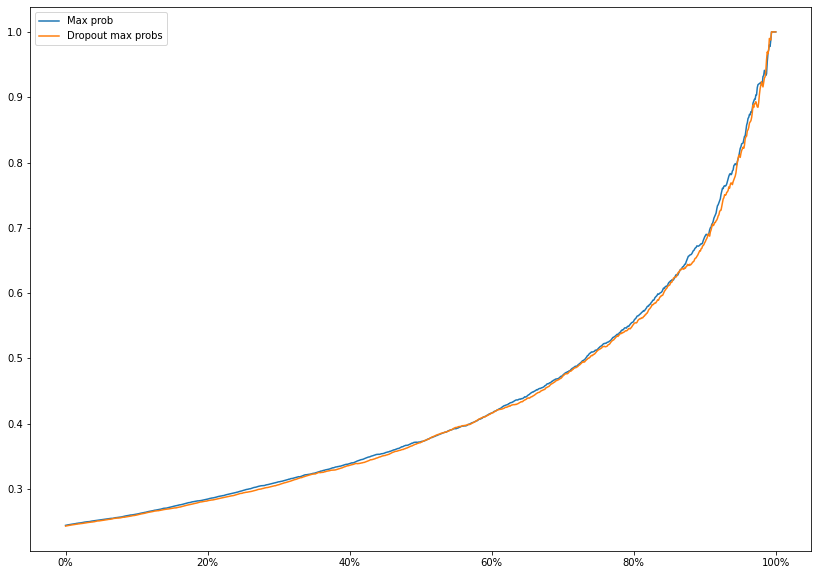

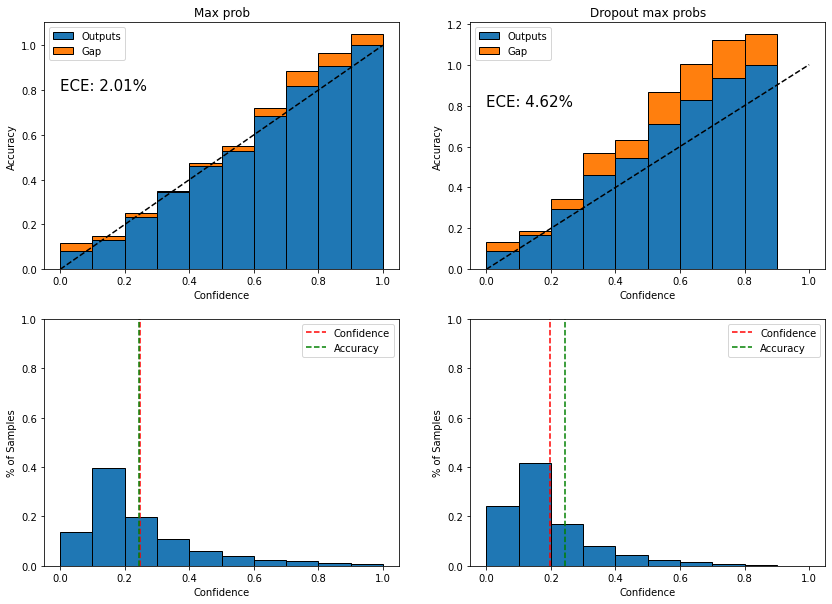

In [ ]:
nll = criterion(torch.tensor(progress.logits), torch.tensor(
    progress.labels, dtype=torch.long)).item()
print(
    f"Accuracy: {(progress.predictions==progress.labels).sum()*100/len(progress.labels):.2f}%, "
    f"NLL: {nll:4f}"
)

# mc_logits = progress.dropout_logits.mean(axis=0)
dropout_max_probs = progress.dropout_outputs.max(axis=-1)

utils.visualisations.samples_removed_vs_acc([
    ("Max prob", np.argsort(progress.max_probs)),
    ("Dropout max probs", np.argsort(dropout_max_probs))],
    progress.labels,
    progress.predictions,
    progress.dropout_predictions)


counts = utils.visualisations.calibration_graph([
    ("Max prob", progress.max_probs, np.argsort(progress.max_probs)),
    ("Dropout max probs", dropout_max_probs, np.argsort(dropout_max_probs))],
    progress.labels,
    progress.predictions,
    progress.dropout_predictions)